In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid

from recsys4daos.models import NLPSimilarity
from recsys4daos.utils import Timer
from recsys4daos.datasets import to_microsoft
from recsys4daos.evaluation import calculate_all_metrics
from recsys4daos.model_selection import cvtt_open, explore_hparams

import paths

import seaborn as sns
sns.set_theme()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/home/daviddavo/recsys4daos/.direnv/python-3.11/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Parameters

In [2]:
# Dataset config
ORG_NAME = 'Decentraland'

# Evaluation
K_RECOMMENDATIONS: list[int] = [1,3,5,10,15,100]
SPLITS_FREQ: str = 'W-THU' # split weekly
SPLITS_NORMALIZE = True # Wether or not to move everything to 00:00
LAST_FOLDS = 10 # Use just last 10 splits
LAST_FOLD_DATE_STR: str = None

# Search space config
WINDOW_SIZES = ['7d', '14d', '21d', '30d', '60d', '90d', '10YE']
MODEL_NAMES = [
    'all-mpnet-base-v2', # The one used in sbert's examples
    'all-distilroberta-v1',
    'all-MiniLM-L12-v2',
    'all-MiniLM-L6-v2',
]

OPTIM_METRIC = 'map@10'

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
ORG_NAME = "dOrg"
SPLITS_FREQ = "2d"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2022-02-18"


In [4]:
EMBEDDINGS_CACHE = Path(paths.DEFAULT_CACHE_PATH) / 'pln-embeddings'

# Load the dataset

In [5]:
dfp = paths.load_proposals(ORG_NAME, text=True)
dfv = paths.load_votes(ORG_NAME)

print(dfp.info())
print(dfv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 343 non-null    object        
 1   author             343 non-null    object        
 2   date               343 non-null    datetime64[us]
 3   start              343 non-null    datetime64[us]
 4   end                342 non-null    datetime64[us]
 5   platform_proposal  343 non-null    object        
 6   title              343 non-null    object        
 7   description        343 non-null    object        
dtypes: datetime64[us](3), object(5)
memory usage: 21.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1782 entries, 0 to 1781
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        1782 non-null   object        
 1   proposal  1782 non-null   object

In [6]:
df = to_microsoft(dfv)
df

,userID,itemID,timestamp,rating
0,0x7f2a1ef39ea0d470b5669ce105a13c5b3bd8cd31,40babd7f-5215-581f-816b-f56d21d3f910,2020-03-06 16:18:05,1
1,0x36dbcbb5c90e9b00ab658353696610cc5d7b7002,40babd7f-5215-581f-816b-f56d21d3f910,2020-03-06 17:33:19,1
2,0xb1b7586656116d546033e3baff69bfcd6592225e,40babd7f-5215-581f-816b-f56d21d3f910,2020-03-06 19:59:20,1
3,0xb1b7586656116d546033e3baff69bfcd6592225e,616fe9b9-c5f2-5571-904c-fb0c09f04e19,2020-03-09 02:15:26,1
4,0x7f2a1ef39ea0d470b5669ce105a13c5b3bd8cd31,616fe9b9-c5f2-5571-904c-fb0c09f04e19,2020-03-12 00:02:44,1
...,...,...,...,...
1777,0x6fe74660d9ccad62f5ce15657e95453f1c54b6fb,ccbd62f1-63d3-5db8-95fd-7854f034bab2,2023-06-29 14:42:01,1
1778,0x04181a9feec83a9692f2126333660e7a0cf13a73,ccbd62f1-63d3-5db8-95fd-7854f034bab2,2023-06-30 15:05:47,1
1779,0xc5d5851a81afc92d49266f73824c2701730b8a6d,ccbd62f1-63d3-5db8-95fd-7854f034bab2,2023-06-30 16:55:15,1
1780,0xd9d41335fee80ede3ba22f33100740c2858f761a,ccbd62f1-63d3-5db8-95fd-7854f034bab2,2023-07-01 14:27:48,1


## Split in folds

In [7]:
all_folds = { f.end:f for f in cvtt_open(
    df, SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', last_fold=LAST_FOLD_DATE_STR,
)}
last_folds_idx = list(all_folds.keys())[-LAST_FOLDS:]
last_folds_idx

[Timestamp('2022-01-31 00:00:00'),
 Timestamp('2022-02-02 00:00:00'),
 Timestamp('2022-02-04 00:00:00'),
 Timestamp('2022-02-06 00:00:00'),
 Timestamp('2022-02-08 00:00:00'),
 Timestamp('2022-02-10 00:00:00'),
 Timestamp('2022-02-12 00:00:00'),
 Timestamp('2022-02-14 00:00:00'),
 Timestamp('2022-02-16 00:00:00'),
 Timestamp('2022-02-18 00:00:00')]

# Similarity PLN

In [8]:
def testHParamsPLNSimilarity(fold, window_size, model_name):
    f = all_folds[fold]
    
    model = NLPSimilarity(dfp, EMBEDDINGS_CACHE, model_name=model_name)

    offset = pd.tseries.frequencies.to_offset(window_size)
    train = f.train[f.train['timestamp'] > (f.end - offset)]

    with Timer() as t_fit:
        model.fit(train)

    with Timer() as t_rec:
        # Truncate the top_k
        top_k = max(K_RECOMMENDATIONS)
        users = np.intersect1d(f.test['userID'].unique(), train['userID'].unique())
        recs = model.recommend_k_items(users, top_k=min(len(f.open_proposals), top_k), recommend_from=f.open_proposals)
    
    return {
        'time_train': t_fit.time,
        'time_rec': t_rec.time,
        'rec_users': len(users),
        **calculate_all_metrics(f.test, recs, K_RECOMMENDATIONS),
    }

# testHParamsPLNSimilarity(last_folds_idx[0], '14D', MODEL_NAMES[0])

In [9]:
# Populate the cache of embeddings for each model
from recsys4daos.models.nlp import NLPModel

for m in MODEL_NAMES:
    NLPModel(dfp, EMBEDDINGS_CACHE, model_name=m).fit()

In [10]:
results = explore_hparams(
    testHParamsPLNSimilarity,
    ParameterGrid({
        'fold': last_folds_idx,
        'model_name': MODEL_NAMES,
        'window_size': WINDOW_SIZES,
    }),
    paths.hparams_progress('pln-similarity', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE),
)
mdf = pd.DataFrame(results)
mdf

Restored checkpoint from ../.cache/dOrg/hparams-pln-similarity_2d_normalize.pkl with 812 results


  0%|          | 0/280 [00:00<?, ?it/s]

,fold,model_name,window_size,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
0,2022-01-31,all-mpnet-base-v2,7d,0.079321,0.001253,10,0.700000,0.400000,0.240000,0.120000,...,1.0,1.0,1.0,0.857143,0.928571,0.928571,0.928571,0.928571,0.928571,0.123470
1,2022-01-31,all-mpnet-base-v2,14d,0.239733,0.001294,12,0.583333,0.333333,0.233333,0.116667,...,1.0,1.0,1.0,0.857143,0.857143,0.857143,0.857143,0.857143,0.857143,0.126346
2,2022-01-31,all-mpnet-base-v2,21d,0.080996,0.001253,12,0.583333,0.333333,0.233333,0.116667,...,1.0,1.0,1.0,0.857143,0.857143,0.857143,0.857143,0.857143,0.857143,0.123705
3,2022-01-31,all-mpnet-base-v2,30d,0.238325,0.001256,12,0.583333,0.333333,0.233333,0.116667,...,1.0,1.0,1.0,0.857143,0.857143,0.857143,0.857143,0.857143,0.857143,0.123489
4,2022-01-31,all-mpnet-base-v2,60d,0.242315,0.001266,13,0.615385,0.384615,0.246154,0.123077,...,1.0,1.0,1.0,0.812500,0.875000,0.875000,0.875000,0.875000,0.875000,0.126431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,2022-02-18,all-MiniLM-L6-v2,21d,0.247960,0.001250,2,0.500000,0.333333,0.200000,0.100000,...,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.127144
276,2022-02-18,all-MiniLM-L6-v2,30d,0.073746,0.001269,2,0.500000,0.333333,0.200000,0.100000,...,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.127433
277,2022-02-18,all-MiniLM-L6-v2,60d,0.248981,0.001274,2,0.500000,0.333333,0.200000,0.100000,...,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.127646
278,2022-02-18,all-MiniLM-L6-v2,90d,0.074918,0.001304,2,0.500000,0.333333,0.200000,0.100000,...,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.127972


<Axes: xlabel='window_size', ylabel='map@10'>

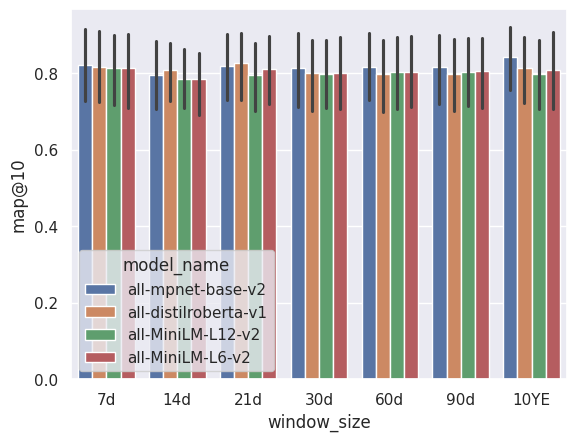

In [11]:
sns.barplot(mdf, x='window_size', y=OPTIM_METRIC, hue='model_name')

## Best overall hparams

In [12]:
display_columns = ['time_train'] + [ c for c in mdf.columns if c.endswith('@5') or c.endswith('@10') or c.endswith('@100') ]
hparam_cols = ['window_size', 'model_name']
overall_hparams = mdf[mdf['fold'] > last_folds_idx[0]].groupby(hparam_cols).mean().sort_values(OPTIM_METRIC, ascending=False)
overall_hparams[display_columns]

time_train  precision@5  precision@10  \
window_size model_name                                                    
10YE        all-mpnet-base-v2       0.168934     0.218201      0.109101   
21d         all-distilroberta-v1    0.183172     0.221667      0.110833   
            all-mpnet-base-v2       0.163533     0.221667      0.110833   
10YE        all-distilroberta-v1    0.169940     0.218201      0.109101   
90d         all-mpnet-base-v2       0.183229     0.218201      0.109101   
60d         all-mpnet-base-v2       0.185430     0.218201      0.109101   
21d         all-MiniLM-L6-v2        0.206639     0.221667      0.110833   
30d         all-mpnet-base-v2       0.182493     0.219259      0.109630   
7d          all-mpnet-base-v2       0.181161     0.222222      0.111111   
10YE        all-MiniLM-L6-v2        0.191598     0.218201      0.109101   
7d          all-distilroberta-v1    0.200033     0.222222      0.111111   
14d         all-distilroberta-v1    0.183125     0.221667      0.110833   
90d         all-MiniLM-L6-v2        0.132115     0.218201      0.109101   
60d         all-MiniLM-L6-v2        0.188940     0.218201      0.109101   
30d         all-MiniLM-L6-v2        0.131343     0.219259      0.109630   
90d         all-MiniLM-L12-v2       0.170321     0.218201      0.109101   
60d         all-MiniLM-L12-v2       0.169191     0.218201      0.109101   
30d         all-MiniLM-L12-v2       0.169097     0.219259      0.109630   
7d          all-MiniLM-L12-v2       0.168452     0.222222      0.111111   
            all-MiniLM-L6-v2        0.223874     0.222222      0.111111   
30d         all-distilroberta-v1    0.203727     0.219259      0.109630   
60d         all-distilroberta-v1    0.147500     0.218201      0.109101   
90d         all-distilroberta-v1    0.206906     0.218201      0.109101   
21d         all-MiniLM-L12-v2       0.149089     0.221667      0.110833   
14d         all-mpnet-base-v2       0.182387     0.221667      0.110833   
10YE        all-MiniLM-L12-v2       0.153962     0.218201      0.109101   
14d         all-MiniLM-L6-v2        0.092787     0.221667      0.110833   
            all-MiniLM-L12-v2       0.169286     0.221667      0.110833   

                                  precision@100    ndcg@5   ndcg@10  ndcg@100  \
window_size model_name                                                          
10YE        all-mpnet-base-v2          0.010910  0.891743  0.891743  0.891743   
21d         all-distilroberta-v1       0.011083  0.789860  0.789860  0.789860   
            all-mpnet-base-v2          0.011083  0.782016  0.782016  0.782016   
10YE        all-distilroberta-v1       0.010910  0.874011  0.874011  0.874011   
90d         all-mpnet-base-v2          0.010910  0.847806  0.847806  0.847806   
60d         all-mpnet-base-v2          0.010910  0.847806  0.847806  0.847806   
21d         all-MiniLM-L6-v2           0.011083  0.779445  0.779445  0.779445   
30d         all-mpnet-base-v2          0.010963  0.804376  0.804376  0.804376   
7d          all-mpnet-base-v2          0.011111  0.613074  0.613074  0.613074   
10YE        all-MiniLM-L6-v2           0.010910  0.868186  0.868186  0.868186   
7d          all-distilroberta-v1       0.011111  0.612083  0.612083  0.612083   
14d         all-distilroberta-v1       0.011083  0.717072  0.717072  0.717072   
90d         all-MiniLM-L6-v2           0.010910  0.841466  0.841466  0.841466   
60d         all-MiniLM-L6-v2           0.010910  0.841466  0.841466  0.841466   
30d         all-MiniLM-L6-v2           0.010963  0.798036  0.798036  0.798036   
90d         all-MiniLM-L12-v2          0.010910  0.839231  0.839231  0.839231   
60d         all-MiniLM-L12-v2          0.010910  0.839231  0.839231  0.839231   
30d         all-MiniLM-L12-v2          0.010963  0.795801  0.795801  0.795801   
7d          all-MiniLM-L12-v2          0.011111  0.607216  0.607216  0.607216   
            all-MiniLM-L6-v2           0.011111  0.607216  0.607216  0.607216   
3

In [13]:
best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])
paths.save_model_results(best_avg_hparams, 'plnsim-best-avg', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_avg_hparams

Saved dataframe into /home/daviddavo/recsys4daos/data/output/dOrg/models/plnsim-best-avg_2d_normalize.parquet


/tmp/ipykernel_3821330/971293119.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])


,,,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
fold,window_size,model_name,,,,,,,,,,,,,,,,,,,,,
2022-01-31,10YE,all-mpnet-base-v2,0.246406,0.001323,15,0.600000,0.400000,0.240000,0.120000,0.080000,0.012000,0.600000,...,1.0,1.0,1.0,0.833333,0.888889,0.888889,0.888889,0.888889,0.888889,0.122257
2022-02-02,10YE,all-mpnet-base-v2,0.089420,0.001384,3,0.333333,0.333333,0.200000,0.100000,0.066667,0.010000,0.333333,...,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.128069
2022-02-04,10YE,all-mpnet-base-v2,0.091929,0.001423,7,0.428571,0.333333,0.200000,0.100000,0.066667,0.010000,0.428571,...,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.129697
2022-02-06,10YE,all-mpnet-base-v2,0.093885,0.001353,7,0.857143,0.428571,0.257143,0.128571,0.085714,0.012857,0.857143,...,1.0,1.0,1.0,0.833333,1.000000,1.000000,1.000000,1.000000,1.000000,0.130623
2022-02-08,10YE,all-mpnet-base-v2,0.268070,0.001380,9,0.888889,0.444444,0.266667,0.133333,0.088889,0.013333,0.888889,...,1.0,1.0,1.0,0.916667,0.944444,0.944444,0.944444,0.944444,0.944444,0.129765
2022-02-10,10YE,all-mpnet-base-v2,0.266882,0.001404,5,1.000000,0.400000,0.240000,0.120000,0.080000,0.012000,1.000000,...,1.0,1.0,1.0,0.900000,1.000000,1.000000,1.000000,1.000000,1.000000,0.130228
2022-02-12,10YE,all-mpnet-base-v2,0.264184,0.001368,4,1.000000,0.333333,0.200000,0.100000,0.066667,0.010000,1.000000,...,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.127942
2022-02-14,10YE,all-mpnet-base-v2,0.264120,0.001226,3,1.000000,0.333333,0.200000,0.100000,0.066667,0.010000,1.000000,...,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.127585
2022-02-16,10YE,all-mpnet-base-v2,0.089828,0.001393,6,0.333333,0.333333,0.200000,0.100000,0.066667,0.010000,0.333333,...,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.127719


## best hparams by fold

In [14]:
print("Best hyperparams by fold", OPTIM_METRIC)
best_hparams = mdf.sort_values(OPTIM_METRIC,ascending=False).drop_duplicates(['fold'], keep='first').sort_values('fold').set_index(['fold', 'model_name', 'window_size'])
paths.save_model_results(best_hparams, 'plnsim-best-val', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_hparams[display_columns]

Best hyperparams by fold map@10
Saved dataframe into /home/daviddavo/recsys4daos/data/output/dOrg/models/plnsim-best-val_2d_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2022-01-31,all-MiniLM-L12-v2,7d,0.220989,0.24,0.12,0.012,0.588290,0.588290,0.588290,0.841667,0.841667,0.841667,1.0,1.0,1.0,0.9375,0.9375,0.9375
2022-02-02,all-mpnet-base-v2,10YE,0.089420,0.20,0.10,0.010,0.753953,0.753953,0.753953,0.666667,0.666667,0.666667,1.0,1.0,1.0,1.0000,1.0000,1.0000
2022-02-04,all-mpnet-base-v2,7d,0.089488,0.20,0.10,0.010,0.661561,0.661561,0.661561,0.900000,0.900000,0.900000,1.0,1.0,1.0,1.0000,1.0000,1.0000
2022-02-06,all-MiniLM-L6-v2,7d,0.241084,0.30,0.15,0.015,0.571429,0.571429,0.571429,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0000,1.0000,1.0000
2022-02-08,all-MiniLM-L6-v2,7d,0.245642,0.30,0.15,0.015,0.666667,0.666667,0.666667,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0000,1.0000,1.0000
2022-02-10,all-mpnet-base-v2,10YE,0.266882,0.24,0.12,0.012,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0000,1.0000,1.0000
2022-02-12,all-MiniLM-L6-v2,60d,0.076045,0.20,0.10,0.010,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0000,1.0000,1.0000
2022-02-14,all-MiniLM-L12-v2,90d,0.245600,0.20,0.10,0.010,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0000,1.0000,1.0000
2022-02-16,all-distilroberta-v1,14d,0.083929,0.20,0.10,0.010,0.438488,0.438488,0.438488,0.833333,0.833333,0.833333,1.0,1.0,1.0,1.0000,1.0000,1.0000


In [15]:
best_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.0,10.0,10.000000,10.000000,10.000000
mean,0.163293,0.228000,0.114000,0.011400,0.749585,0.749585,0.749585,0.899167,0.899167,0.899167,1.0,1.0,1.0,0.993750,0.993750,0.993750
std,0.085947,0.041312,0.020656,0.002066,0.200456,0.200456,0.200456,0.122377,0.122377,0.122377,0.0,0.0,0.0,0.019764,0.019764,0.019764
min,0.073852,0.200000,0.100000,0.010000,0.438488,0.438488,0.438488,0.666667,0.666667,0.666667,1.0,1.0,1.0,0.937500,0.937500,0.937500
25%,0.085301,0.200000,0.100000,0.010000,0.606608,0.606608,0.606608,0.835417,0.835417,0.835417,1.0,1.0,1.0,1.000000,1.000000,1.000000
50%,0.155238,0.200000,0.100000,0.010000,0.710310,0.710310,0.710310,0.950000,0.950000,0.950000,1.0,1.0,1.0,1.000000,1.000000,1.000000
75%,0.244471,0.240000,0.120000,0.012000,0.953866,0.953866,0.953866,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000
max,0.266882,0.300000,0.150000,0.015000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000


### Results of using best hparams on next fold

In [16]:
next_hparams_idx = best_hparams.index.to_frame(False)
next_hparams_idx['fold'] = next_hparams_idx['fold'].shift(-1)
next_hparams_idx = next_hparams_idx.dropna()
assert len(next_hparams_idx) == len(best_hparams)-1
next_hparams = mdf.set_index(['fold', 'model_name', 'window_size']).loc[pd.MultiIndex.from_frame(next_hparams_idx)]
paths.save_model_results(next_hparams, 'plnsim-best-test', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
next_hparams[display_columns]

Saved dataframe into /home/daviddavo/recsys4daos/data/output/dOrg/models/plnsim-best-test_2d_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2022-02-02,all-MiniLM-L12-v2,7d,0.242399,0.2,0.10,0.010,0.420620,0.420620,0.420620,0.500000,0.500000,0.500000,1.0,1.0,1.0,NaN,NaN,NaN
2022-02-04,all-mpnet-base-v2,10YE,0.091929,0.2,0.10,0.010,0.789103,0.789103,0.789103,0.714286,0.714286,0.714286,1.0,1.0,1.0,1.0,1.0,1.0
2022-02-06,all-mpnet-base-v2,7d,0.087332,0.3,0.15,0.015,0.571429,0.571429,0.571429,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
2022-02-08,all-MiniLM-L6-v2,7d,0.245642,0.3,0.15,0.015,0.666667,0.666667,0.666667,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
2022-02-10,all-MiniLM-L6-v2,7d,0.245812,0.2,0.10,0.010,0.452372,0.452372,0.452372,0.666667,0.666667,0.666667,1.0,1.0,1.0,1.0,1.0,1.0
2022-02-12,all-mpnet-base-v2,10YE,0.264184,0.2,0.10,0.010,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
2022-02-14,all-MiniLM-L6-v2,60d,0.071755,0.2,0.10,0.010,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
2022-02-16,all-MiniLM-L12-v2,90d,0.074160,0.2,0.10,0.010,0.753953,0.753953,0.753953,0.666667,0.666667,0.666667,1.0,1.0,1.0,1.0,1.0,1.0
2022-02-18,all-distilroberta-v1,14d,0.084727,0.2,0.10,0.010,0.815465,0.815465,0.815465,0.750000,0.750000,0.750000,1.0,1.0,1.0,1.0,1.0,1.0


In [17]:
next_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.0,9.0,9.0,8.0,8.0,8.0
mean,0.156438,0.222222,0.111111,0.011111,0.718845,0.718845,0.718845,0.810847,0.810847,0.810847,1.0,1.0,1.0,1.0,1.0,1.0
std,0.088716,0.044096,0.022048,0.002205,0.211542,0.211542,0.211542,0.191815,0.191815,0.191815,0.0,0.0,0.0,0.0,0.0,0.0
min,0.071755,0.200000,0.100000,0.010000,0.420620,0.420620,0.420620,0.500000,0.500000,0.500000,1.0,1.0,1.0,1.0,1.0,1.0
25%,0.084727,0.200000,0.100000,0.010000,0.571429,0.571429,0.571429,0.666667,0.666667,0.666667,1.0,1.0,1.0,1.0,1.0,1.0
50%,0.091929,0.200000,0.100000,0.010000,0.753953,0.753953,0.753953,0.750000,0.750000,0.750000,1.0,1.0,1.0,1.0,1.0,1.0
75%,0.245642,0.200000,0.100000,0.010000,0.815465,0.815465,0.815465,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
max,0.264184,0.300000,0.150000,0.015000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
